### <b> Recreating Mocquet 1999 and Raevskiy et al. 2015 <b>

To do:
1. Come up with a seismic model for Venus
2. Find an estimate of the seismic attentuation on Venus

<b> Approach </b>

3. Aki and Richards (1980) has a solution for amplitude of ground acceleration in the far-field at a speciffic frequency omega

a = 4*pi*(omega)**3 * rho * c * M(w) * rho_n * c **5 * F(r, r_n) * R(r, r_n) * A(r, r_n, omega)
where rho = density, c = P or S wave velocity, subscript n referes to being evaluated at the source, M, R and A are the frequency dependent scalar seismic moment, the geometrical spreading and the correction due to attenuation, respectively. F includes radiation factor, transmission coefficient at crust-mantle interface, and free surface correction term.


<b> 1. Source model / radiation pattern </b>

F - assume a simple isotropic source
Frequency dependence of seismic moment is assumed to follow Sato and Hiraswas 1973 whoch provides the 1 / omega**2 decay given by M(w) = M0 / (1 - (omega/omega_0))**2
- vary M(0) based in the moment distribution estimated previously
- corner frequencies are defined based on empirical scaling laws

<b> 2. Geometric spreading </b>

Use equation 6 from Kanamori and Stewart 1976. Same equation also in Duda. Also in Julian and Anderson. 
- For a surface focus, the density and wave velovcity at both the the focus and the station are the same. 
- Assume i = 0 to 25 deg. 
- For d_i/d_del, use the curve plotted in figure 8. 
- Vary epicentral distance between 20 and 90 seg.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from obspy.taup import TauPyModel

In [2]:
## setting a velocity model
## vt1cold is computed using Dumoulin et al. 2017 V1 cold 
## for more info on how to make this model - refer to the notes
model = TauPyModel(model="v1tcold")

In [16]:
def far_field_disp_spectra(M0, omega):

    log10_omega0_P = 5 - .35 * np.log10(M0)
    omega0_P = 2*np.pi * 10**(log10_omega0_P)
    log10_omega0_S = log10_omega0_P - .2
    omega0_S = 2*np.pi * 10**(log10_omega0_S)
    # print(omega0_P, omega0_S)
    
    M_P = M0 / (1 + (omega / omega0_P))**2
    M_S = M0 / (1 + (omega / omega0_S))**2
    return M_P, M_S

def seismic_attenuation(omega, epi_dist, Q=500, t=1, A0 = 1):
    
    ### compute travel times
    arrivals = model.get_ray_paths(source_depth_in_km = 0, distance_in_degree = epi_dist, receiver_depth_in_km = 0)
    travel_times_P = arrivals[0].time
        #travel_times_S = arrivals[1].time
        
    A_P = A0 * np.exp(-1*omega*travel_times_P / (2*Q))
    # A_S = A0 * np.exp(-1*omega*travel_times_S / (2*Q))
    # A = A0 * np.exp(-2*np.pi*omega/ (2*Q))
    return A_P

def geom_spreading(i_deg, epi_dist_deg, epi_dist):
    # pradius = 6051.8
    # i_rad = np.deg2rad(i_deg)
    # epi_dist_rad = np.deg2rad(epi_dist_deg)
    # takeoff_over_epidist = (33-0) / (30-90)
    # div = np.sqrt(np.sin(i_rad) / (pradius ** -2 * np.sin(epi_dist_rad) * np.cos(i_rad)) * np.abs(takeoff_over_epidist))
    arrivals = model.get_ray_paths(source_depth_in_km = 0, distance_in_degree = epi_dist, receiver_depth_in_km = 0)
    travel_dist_deg_P = arrivals[0].distance
    travel_dist_km_P = (travel_dist_deg_P/360) * 2*np.pi*6051.8**2
    div = travel_dist_km_P
    
    return div

def amplitude_ground_acc(M0, omega, rho, c, i_deg, epi_dist_deg, Q, wavetype = 'P'):
    M_P, M_S = far_field_disp_spectra(M0, omega)
    if wavetype == 'P':
        M = M_P
    elif wavetype == 'S':
        M = M_S
    A = seismic_attenuation(omega, epi_dist_deg, Q)
    R = geom_spreading(i_deg, epi_dist_deg, epi_dist_deg)
    a = omega**3 * M * A /(4*np.pi * np.sqrt(rho * c) * math.sqrt(rho * c**5) * R)
    return a

In [17]:
# M0 = np.array([1e13, 1e15, 1e14])
# omega = np.linspace(.01, 10, 50)
# Mw_P = np.zeros((len(M0), len(omega)), dtype=float)
# Mw_S = np.zeros((len(M0), len(omega)), dtype=float)

# fig, ax = plt.subplots(1,1)
# fig.set_size_inches(7,7)   
# colors = ["#006ddb","#b66dff","#000000", "#920000", "#85b66f", "#a47158", "#924900","#db6d00","#24ff24","#ffff6d"]

# for i, m0 in enumerate(M0):
#     Mw_P[i,:], Mw_S[i,:] = far_field_disp_spectra(m0, omega)   
#     ax.plot(omega, Mw_P[i], c = colors[i], label = str(m0))
#     ax.plot(omega, Mw_S[i], c = colors[i], linestyle = "-.", label = str(m0))

# ax.set_xlabel("Frequency (Hz)")
# ax.set_ylabel("Far field displacement spectra")
    
# # plt.yscale('symlog', base=10)
# ax.set_xscale('log',base=10) 
# ax.set_yscale('log',base=10) 

# plt.legend()
# plt.show()

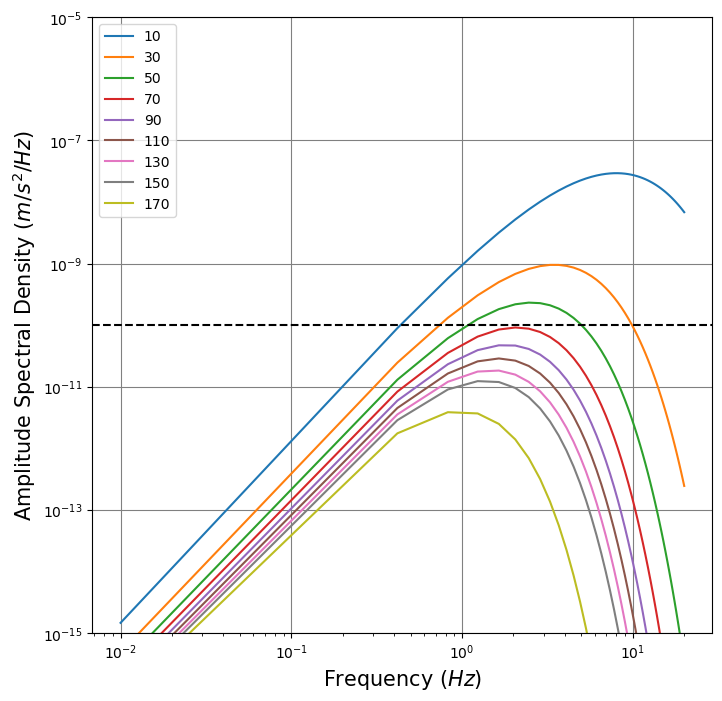

In [65]:
rho = 2700
c_S = 3000          ## p wave velocity of 5 km/s
c_P = 5000          ## s wave velocity of 3 km/s
i_deg = 25
Q = 250
omega = np.linspace(.01, 20, 50)


epi_dist = np.arange(10, 180, 20)
A_P = np.zeros((len(epi_dist), len(omega)), dtype=float)
A_S = np.zeros((len(epi_dist), len(omega)), dtype=float)
moment = 4e13

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8, 8)   
colors = ["#006ddb","#b66dff","#000000", "#920000", "#85b66f", "#a47158", "#924900","#db6d00","#24ff24","#ffff6d"]


for i, epi in enumerate(epi_dist):
    A_P[i, :] = amplitude_ground_acc(moment, omega, rho, c_P, i_deg, epi, Q, 'P')
    A_S[i, :] = amplitude_ground_acc(moment, omega, rho, c_S, i_deg, epi, Q, 'S')
    
    ax.plot(omega, A_P[i], label = str(epi))
    # ax.plot(omega, A_S[i], c = colors[i], linestyle = "-.", label = str(epi))

ax.set_xlabel("Frequency " + "$ (Hz)$", fontsize = 15)
ax.set_ylabel("Amplitude Spectral Density " + "$(m/s^2/Hz)$", fontsize = 15)
    
# plt.yscale('symlog', base=10)
ax.set_xscale('log',base=10) 
ax.set_yscale('log',base=10) 

ax.set_ylim(1e-15, 1e-5)
ax.grid(axis = "x", which = "major", c = "grey")
ax.grid(axis = "y", which = "major", c = "grey")
ax.axhline(1e-10, c = 'k', linestyle="--")

plt.legend()
plt.savefig("magnitude3_acceleration_ASD.png")
plt.show()

In [6]:
model = TauPyModel(model="v1tcold")

In [37]:
for i in [20, 30, 40, 50, 60, 70, 80, 90, 100]:
    arrivals = model.get_ray_paths(source_depth_in_km = 0, distance_in_degree = i, receiver_depth_in_km = 0)
    print(arrivals[0].time, arrivals[0].distance, arrivals[0].purist_dist)

266.8772614153834 20 0.3490658503988659
362.6866293578746 30 0.5235987755982988
441.02955108969843 40 0.6981317007977318
515.1042801223014 50 0.8726646259971648
583.2077937867069 60 1.0471975511965976
644.7453291723268 70 1.2217304763960306
699.5560192146455 80 1.3962634015954636
747.930505936145 90 1.5707963267948966
793.0309982523207 100 1.7453292519943295


/tmp/ipykernel_121/1603124891.py:2: ObsPyDeprecationWarning: The plot() function is deprecated. Please use arrivals.plot_rays()
  arrivals.plot()


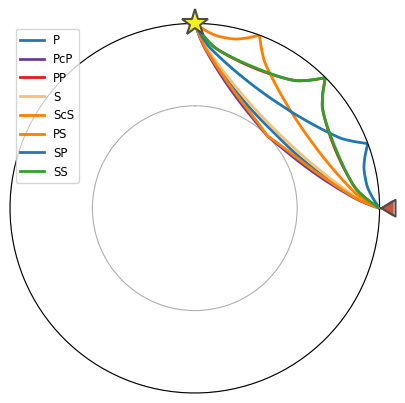

<PolarAxesSubplot:>

In [36]:
arrivals = model.get_ray_paths(source_depth_in_km = 0, distance_in_degree = 90, receiver_depth_in_km = 0)
arrivals.plot()

In [ ]:
np.interp(1e-15, )

In [27]:
m = [3.98e10, 3.162e11, 2.512e12,1.995e13, 1.585e14, 1.26e15, 1e16, 7.95e16,6.3e17, 5e18]
n = [90331, 22534, 5621, 1402, 350, 87, 22, 5,1,.25]
np.interp(120, m, n)

90331.0

In [23]:
120 * 68587 / 365

22549.15068493151